# Step 2
### Data Viz
<br>

----

#### Load Cities File

In [1]:
import pandas as pd
import numpy as np


In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone


In [3]:
cities_data = pd.read_pickle("../data/pickles/cities_1.pkl")


#### Make City Centers

In [4]:
center_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', GaussianMixture(random_state=42))
])

latitude_bounds = []
longitude_bounds = []

city_centers = []
city_ratios = []

for cur_row in cities_data.itertuples():
    tmp_data = cur_row.rentals[["latitude", "longitude", "price"]].copy()
    tmp_data["log_price"] = np.log10(tmp_data.price)
    del tmp_data["price"]
    
    cloned_pipeline = clone(center_cluster_pipeline).fit(tmp_data)
    
    cur_probas = -1 * cloned_pipeline.score_samples(tmp_data)
    focus_indices = np.argsort(cur_probas)[0:int(np.ceil(len(cur_probas)*0.625))]

    tmp_data = tmp_data.iloc[focus_indices]
    
    latitude_bounds.append(
        ( np.min(tmp_data.latitude), np.max(tmp_data.latitude) )
    )
    
    longitude_bounds.append(
        ( np.min(tmp_data.longitude), np.max(tmp_data.longitude) )
    )
    
    city_latitude, city_longitude = cloned_pipeline.steps[0][-1].inverse_transform(
        cloned_pipeline.steps[-1][-1].means_
    )[0][0:-1]
    
    city_centers.append(
        (city_latitude, city_longitude)
    )

    meter_per_latitude = 69.17
    meter_per_longitude = np.cos( city_latitude * ( 2*np.pi / 360 ) ) * ( 24900 / 360 )
    
    city_ratios.append(meter_per_latitude / meter_per_longitude)

cities_data["latitude_bounds"] = latitude_bounds
cities_data["longitude_bounds"] = longitude_bounds

cities_data["city_centers"] = city_centers
cities_data["city_ratios"] = city_ratios


In [5]:
cities_data.to_pickle("../data/pickles/cities_2.pkl")


#### Plot City Rentals

In [6]:
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath(os.path.join('../src')))

from plots.make_rentals_plot import make_rentals_plot


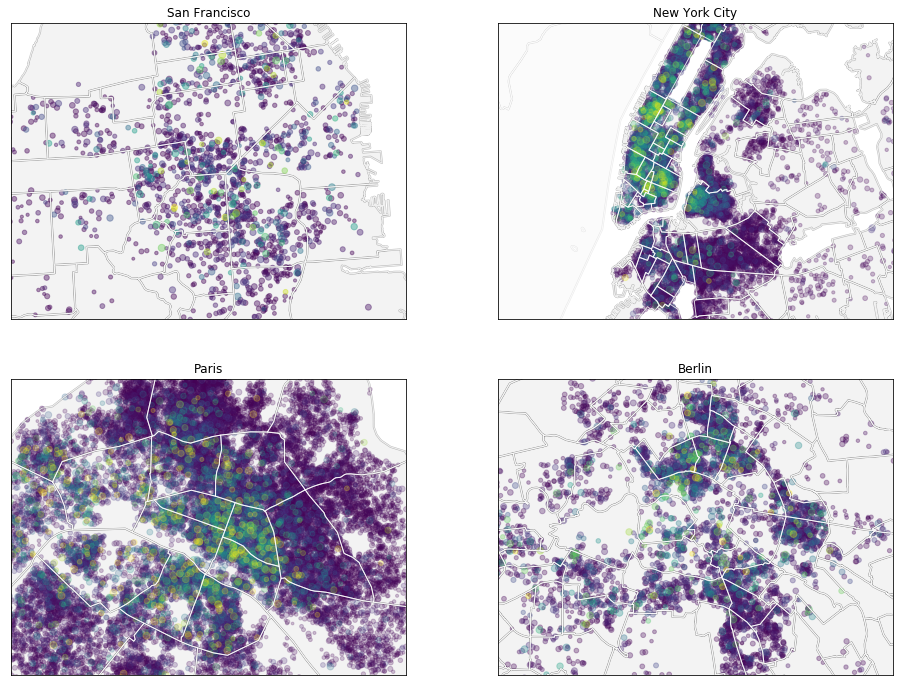

In [7]:
plt.figure(figsize=(16,12))
    
for cur_index, cur_city_data in enumerate(cities_data.itertuples()):
    plt.subplot(2,2,cur_index+1)
    make_rentals_plot(cur_city_data)
